In [31]:
from sklearn.datasets import make_moons, make_circles
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

Observe how for large datasets (`>1e6` data items) theano starts being faster

## Using scipy minimizer

In [280]:
class LR:
    
    def fit(self, X, y):
        
        def cost(t):
            b, W = t[0], t[1:]
            return np.sum((self.g(b+X.dot(W))-y)**2)/len(X)

        start_time = time.time()
        r = minimize(cost, np.zeros(X.shape[1]+1), method="BFGS")
        elapsed_time = time.time()-start_time
        print "elapsed time", elapsed_time
        self.params = r.x 
        self.r = r

    def predict(self, X):
        b, W = self.params[0], self.params[1:]
        return (self.g(b+X.dot(W))>0.5)*1

    def g(self, X):
        return 1/(1+np.exp(-X))
    
    def score(self, X,y):
        return np.sum(self.predict(X)==y)*1./len(X)



In [286]:
X,y = make_moons(1e6, noise=.2)
lr = LR()
lr.fit(X,y)
print "score", lr.score(X,y)
lr.r

elapsed time 6.78692603111
score 0.87016


      fun: 0.09027549968887236
 hess_inv: array([[  59.72258494,   -8.81622275,  -78.10047581],
       [  -8.81622275,   43.91074884,  -66.94233054],
       [ -78.10047581,  -66.94233054,  434.30157448]])
      jac: array([ -3.59956175e-06,  -4.66592610e-06,  -2.07871199e-06])
  message: 'Optimization terminated successfully.'
     nfev: 125
      nit: 24
     njev: 25
   status: 0
  success: True
        x: array([ 0.51939516,  1.11975419, -4.31931173])

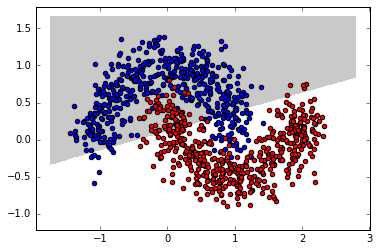

In [282]:
idxs = np.random.permutation(len(X))[:1000]
plot_2Ddata_with_boundary(lr.predict, X[idxs],y[idxs])


## Theano implementation

In [287]:
from theano import tensor as T
import theano

tX = T.matrix('X')
ty = T.vector('y')

X = X.astype(theano.config.floatX)
y = y.astype(theano.config.floatX)

cols = X.shape[1]
W  = np.random.random(cols)
b  = np.random.random()
tW = theano.shared(value=W, name="W", borrow=True)
tb = theano.shared(value=b, name="b", borrow=True)
predictions = 1./(1.+T.exp( - (tb + T.dot(tX, tW))))
cost        = ((predictions - ty)**2).sum()/len(X)

learning_rate = 20.
g_W = T.grad(cost=cost, wrt=tW)
g_b = T.grad(cost=cost, wrt=tb)
updates = [ (tW, tW-learning_rate*g_W),
            (tb, tb-learning_rate*g_b) ]


In [288]:
train_model = theano.function(
    inputs=[],
    outputs=cost,
    updates=updates,
    givens={tX: X, ty: y}
)

In [292]:
import time
start_time = time.time()
prev_params = np.array([tb.get_value()] + list(tW.get_value()))
for i in range(10000):
    train_model()
    params = np.array([tb.get_value()] + list(tW.get_value()))
    if np.linalg.norm(params-prev_params)<1e-2:
        break
    prev_params = params
elapsed_time = time.time()-start_time
print "n its", i, "time", elapsed_time

n its 0 time 0.284139871597


score 0.870031


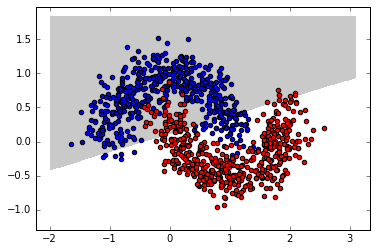

In [293]:
params = np.array([tb.get_value()] + list(tW.get_value()))
lr = LR()
lr.params = params
print "score", lr.score(X,y)
idxs = np.random.permutation(len(X))[:1000]
plot_2Ddata_with_boundary(lr.predict, X[idxs],y[idxs])

In [261]:
lr.score(X,y)

0.87044999999999995

In [297]:
fg_W = theano.function(inputs=[], outputs=g_W, givens={tX: X,ty: y})
fg_b = theano.function(inputs=[], outputs=g_b, givens={tX: X,ty: y})

In [298]:
fg_W(), fg_b()

(array([ -5.30366753e-05,   4.21328480e-04]), array(-8.488318989869289e-05))